# Chebyshev補間の求根

Chebyshev補間によって与えられた関数

$$ p(x)=\sum_{k=0}^{n}a_kT_k(x),\quad a_{n}\neq 0$$

の零点 ( $p(x)=0$ をみたす $x$ ) は、以下の行列 $C$ の固有値を求めることによって得られる。


$$
C=
\begin{pmatrix}
0 & 1 & & & & \\
\frac{1}{2} & 0 & \frac{1}{2} & & & \\
 & \frac{1}{2} & 0 & \frac{1}{2} & & \\
 & &\ddots &\ddots & \ddots& \\
 & & & & & \frac{1}{2} \\
 & & & & \frac{1}{2} & 0 \\
\end{pmatrix}
- \frac{1}{2a_n}
\begin{pmatrix}
& & & & \\
& & & & \\
& &\huge 0 & & \\
& & & & \\
& & & & \\
a_0 & a_1 & a_2 & \cdots & a_{n-1}\\
\end{pmatrix}
$$

この行列 $C$ を**Colleague Matrix**（文献1）という。

以下では、$p(x) = x(x-1/2)(x-2)$ を例としてColleague Matrixを用いた求根のアルゴリズムを紹介する。

In [1]:
versioninfo()

Julia Version 1.10.0
Commit 3120989f39b (2023-12-25 18:01 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 14 × Apple M3 Max
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, apple-m1)
  Threads: 14 on 10 virtual cores
Environment:
  JULIA_NUM_THREADS = auto


In [2]:
using Pkg
Pkg.status("IntervalArithmetic")

Status `~/.julia/environments/v1.10/Project.toml`
  [d1acc4aa] IntervalArithmetic v0.22.6


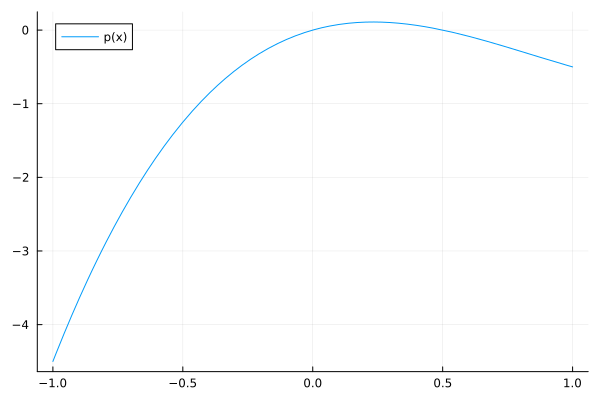

In [3]:
include("FourierChebyshev.jl")
p(x) = x*(x-1/2)*(x-2)
plot(p,-1,1,label="p(x)")

`cheb`関数を用いて $p$ のChebyshev係数を計算すると

In [4]:
a = cheb(p)

4-element Vector{Float64}:
 -1.25
  1.75
 -1.25
  0.24999999999999997

となる。Colleague Matrix $C$ の固有値を求め、$p(x)$ 上にプロットする。

In [5]:
C = [0 1 0; 1/2 0 1/2; 0 1/2 0] - (1/(2*a[4]))*[0 0 0; 0 0 0; a[1:3]']

3×3 Matrix{Float64}:
 0.0   1.0  0.0
 0.5   0.0  0.5
 2.5  -3.0  2.5

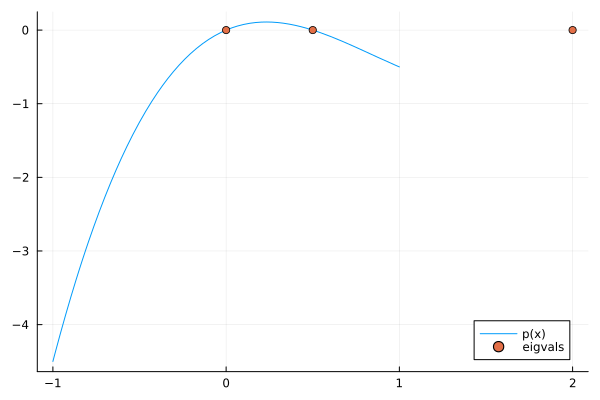

In [6]:
using LinearAlgebra
x = eigvals(C)
scatter!(x,[0,0,0],label="eigvals")

Colleague Matrix $C$ の固有値の一部と $p(x)$ の零点が一致している。
この方法を利用して、Chebyshev係数から零点を求める関数`chebroots`関数を作成する（関数内の各工程は下の例4で詳しく紹介する）。

In [7]:
function chebroots(a, I=[-1,1]) # Input is two-sided Chebyshev
    I_lo = I[1]; I_up = I[2]
    n = length(a)
    # create colleague matrix
    du = [1; ones(n-3)*0.5]
    dl = ones(n-2)*0.5
    d  = zeros(n-1)
    A  = Tridiagonal(dl, d, du)
    B = zeros(n-1,n-1)
    B[end,:] = a[1:end-1]
    C = A - (1/(2*a[n]))*B
    x = eigvals(C)    
    ε = 100*eps()*(I_up-I_lo)*0.5 
    if I_lo==-1.0 && I_up==1.0
        return real(x[(-1-ε .≤ real(x) .≤ 1+ε) .& (imag(x) .≈ 0)])
    else
        x = real(x[(-1-ε .≤ real(x) .≤ 1+ε) .& (imag(x) .≈ 0)])
        return (1.0 .- x).*I_lo/2 + (1.0 .+ x).*I_up/2
    end
end 

chebroots (generic function with 2 methods)

`chebroots`関数を用いてChebyshev補間によって与えられた関数の零点を計算する。

### 例1
$f(x)=\sin\pi x$



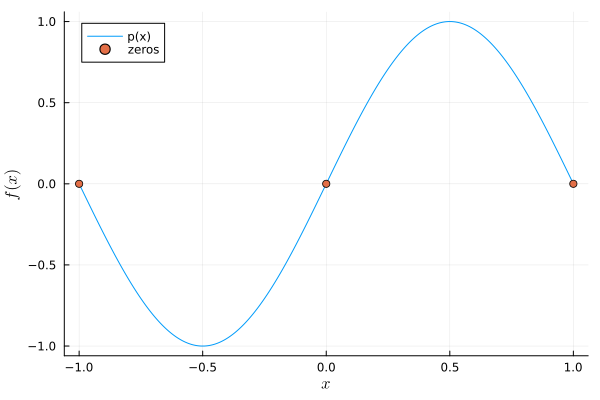

In [8]:
f(x) = sinpi(x)
a = cheb(f)
plot_cheb(a,label="p(x)")
x = chebroots(a)
scatter!(x,zeros(length(x)),label="zeros")

### 例2
$f(x)=\exp\left(\mathrm{erf}(x^2)+x^5\right)\sin(5\pi x)+x$

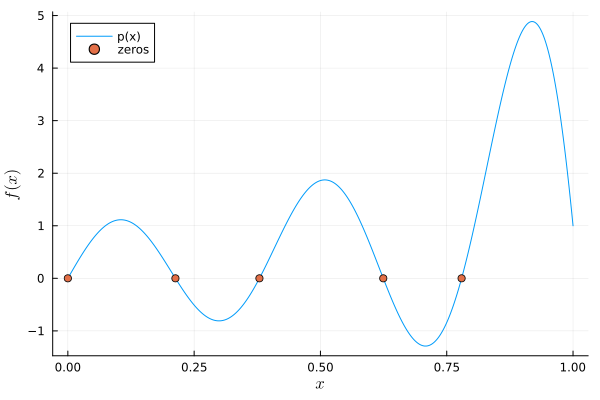

In [9]:
using SpecialFunctions
f(x) = exp(erf(x^2)+x.^5).*sinpi(5x) + x
dom = [0,1]
a = cheb(f,dom)
plot_cheb(a,I=dom,label="p(x)")
x = chebroots(a,dom)
scatter!(x,zeros(length(x)),label="zeros")

### 例3
$f(x)=\cos(n\pi x)$ について $n=3,50,500$ の時の零点を計算し、計算にかかる時間を調べると
$n$ の値が大きくなるにつれて、零点の数が増えるため計算に時間がかかる。

length(a) = 33
  0.000145 seconds (34 allocations: 72.844 KiB)


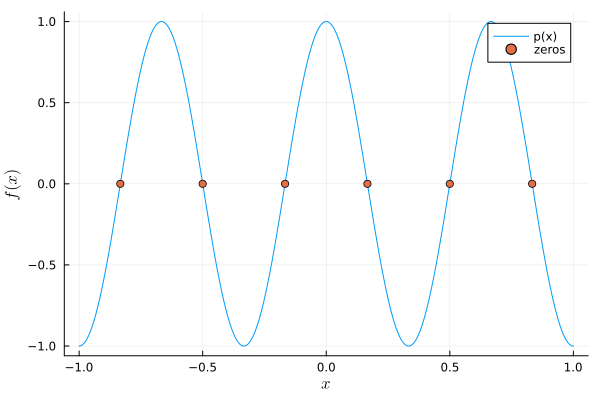

In [10]:
f(x) = cospi(3x)
a = cheb(f)
plot_cheb(a,label="p(x)")
@show length(a)
@time r = chebroots(a)
# length(r)
scatter!(r,zeros(length(x)),label="zeros")

In [11]:
f(x) = cospi(50x)
a = cheb(f)
@show length(a)
@time r = chebroots(a)
length(r)
# r[[1,2,51,99,100]]

length(a) = 213
  0.014635 seconds (38 allocations: 1.459 MiB)


100

In [12]:
f(x) = cospi(500x)
a = cheb(f)
@show length(a)
@time r = chebroots(a)
length(r)
# r[[1,2,501,999,1000]]

length(a) = 2031
  1.523043 seconds (42 allocations: 126.585 MiB, 0.65% gc time)


1000

`chebroots`関数の実装ではChebyshev補間の項数が増大すると、計算時間がかかってしまう。この問題を解決するためには、補間を行う区間を適当に分割して各区間ごとに求根する方法を実装することで、計算時間を短縮できる（今後、紹介予定）。

## Chebyshev補間の求根の精度保証

Chebyshev係数が区間で入力された場合の零点の計算を紹介する。はじめに[部分固有対の精度保証付き数値計算](https://www.risk.tsukuba.ac.jp/~takitoshi/tutorial/verifyeig.html)で実装した`verifyeig`関数を利用する。

In [28]:
using IntervalArithmetic
function verifyeig(iA::Matrix{Interval{T}},lam,x,B = Matrix{T}(I,size(iA))) where T
    x = x ./ sqrt(x' * x)
    ysize = length(x)

    # A = mid.(iA)
    # DF = [0 transpose(2 * x); -B*x A-lam*B]
    # z = -DF\[dot(x,x)-1;A*x-lam*B*x]
    # ϵ = 2*maximum(sup,abs.(z))
    # # ϵ = 2 * maximum(sup,abs.(z)) + 2^(-1074)
    # r = abs.(mid.(z))
    # @show u = r .+ (sum(r)/length(r))
    # ϵ0 = u[1]
    # ϵ = u[2:end]
    # ϵ = 2*maximum(z) 


    ϵ = 1e-9 # size of candidate vector

    if isreal(lam) && isreal(x)
        lam = real(lam)
        x = real(x)
        id = interval(0, ϵ; format=:midpoint)
        iy = interval.(zeros(ysize), ϵ; format=:midpoint)
        iI = interval(Matrix{Float64}(I, ysize + 1, ysize + 1))
        izero = interval(0)
    else
        id = Complex(interval.(0, ϵ; format=:midpoint), interval.(0, ϵ; format=:midpoint))
        iy = Complex.(interval.(zeros(ysize), ϵ; format=:midpoint), interval.(zeros(ysize), ϵ; format=:midpoint))
        iI = interval(Matrix{Complex{Float64}}(I, ysize + 1, ysize + 1))
        izero = interval(0 + 0im)
    end
    iw = [id; iy]

    # DF(w) = [0 transpose(2*(x+w[2:end])) ; -B*(x+w[2:end]) A-(lam+w[1]).*B]
    ix = interval(x)
    ilam = interval(lam)
    # iA = interval(A)
    iB = interval(B)

    iDF(w) = [izero transpose(interval(2) * (ix + w[2:end])); -iB*(ix+w[2:end]) iA-(ilam.+w[1])*iB]
    R = inv(mid.(iDF(zeros(ysize + 1))))
    iR = interval(R)
    z = -iR * [dot(ix, ix) - interval(1); iA * ix - ilam * iB * ix]
    g(w) = z + (iI - iR * iDF(w)) * w
    gw = g(iw)
    if all(issubset_interval.(gw, iw))
        while maximum(radius, gw) / norm([lam; x], 1) > 5e-13
            iw = gw
            gw = g(iw)
        end
        return ilam + gw[1]
    else
        return NaN
    end
end

verifyeig (generic function with 2 methods)

### 例4
$f(x) = \exp\left(\mathrm{erf}(x^2)+x^{5}\right)\sin(5\pi x)+x$ をChebyshev補間したChebyshev係数 $a$ におけるColleague Matrixを計算する。

In [14]:
f(x) = exp(erf(x^2) + x.^5) .* sinpi(5x) + x
# f(x) = exp(x)-1
a = cheb(f)
ia = interval(a)
n = length(ia)
du = [ones(n-3)*0.5; 1]
dl = ones(n-2)*0.5
d  = zeros(n-1)
C_1  = Tridiagonal(dl, d, du)
iC_1 = interval(C_1)
iC_2 = interval(zeros(n-1,n-1))
iC_2[:,1] = reverse(ia[1:end-1]/ia[n])
iC_2 = interval(0.5)*iC_2
C = iC_1-iC_2
C_mid = mid.(C)

52×52 Matrix{Float64}:
    1.27385     0.5  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   -0.32412     0.0  0.5  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   -4.41409     0.5  0.0  0.5  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   19.2574      0.0  0.5  0.0  0.5  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  -41.5846      0.0  0.0  0.5  0.0  0.5     0.0  0.0  0.0  0.0  0.0  0.0  0.0
   35.4399      0.0  0.0  0.0  0.5  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  158.438       0.0  0.0  0.0  0.0  0.5     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -784.309       0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1425.91        0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 -302.143       0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
    ⋮                               ⋮    ⋱  ⋮                        ⋮    
    2.69697e13  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
    4.73005e13  0.0  0.0  0.0  0.0  0.0     

Colleague Matrix の近似固有値、近似固有ベクトルを計算し、「近似固有値の実部が区間 $[-1,1]$内、かつ、虚部がほぼ $0$」になる近似固有値、近似固有ベクトルを抽出する。

In [15]:
lam, x = eigen(C_mid)
ε = 100*eps()
ind = findall((-1-ε .≤ real(lam) .≤ 1+ε) .& (imag(lam) .≈ 0))
lam = real(lam[ind])  
x = real(x[:,ind]) #Approximate eigenvector

52×9 Matrix{Float64}:
  1.65751e-15   1.92725e-15   2.2898e-15   …  -1.34695e-15   8.19548e-16
 -6.75248e-15  -7.33858e-15  -7.56904e-15      1.74962e-15  -8.10429e-16
  1.13798e-14   1.04967e-14   7.22044e-15      1.3117e-15   -7.3206e-16
  4.01804e-15   1.11258e-14   2.23119e-14     -1.20028e-14   6.90439e-15
 -8.13506e-14  -9.87436e-14  -1.1232e-13       3.55772e-14  -2.00698e-14
  2.5799e-13    2.73589e-13   2.5325e-13   …  -5.5595e-14    2.99714e-14
 -4.29865e-13  -3.82608e-13  -2.41903e-13     -9.53004e-15   8.70071e-15
 -1.27175e-13  -4.0216e-13   -7.95509e-13      4.7051e-13   -2.76103e-13
  3.22396e-12   3.91248e-12   4.4366e-12      -1.51577e-12   8.4646e-13
 -9.52001e-12  -1.00241e-11  -9.09681e-12      1.47792e-12  -7.41611e-13
  ⋮                                        ⋱                
 -0.0124885    -0.265016     -0.48935          0.329413     -0.0937951
  0.16955       0.391214      0.00927473       0.473011     -0.261668
 -0.403073     -0.410273      0.265703     …   0

In [16]:
ilam = interval(zeros(length(lam)))
for i = 1:length(lam)
     ilam[i] = verifyeig(C,lam[i],x[:,i])
end
ilam

9-element Vector{Interval{Float64}}:
 [-0.763077, -0.763075]_com
 [-0.63005, -0.630049]_com
 [-0.378919, -0.378918]_com
 [-0.212978, -0.212977]_com
 [-8.10175e-18, 3.22727e-17]_com
 [0.212965, 0.212966]_com
 [0.379245, 0.379246]_com
 [0.624377, 0.624378]_com
 [0.779416, 0.779417]_com

計算した固有値の区間包含の中点と関数 $f(x)$ を重ねて描画すると

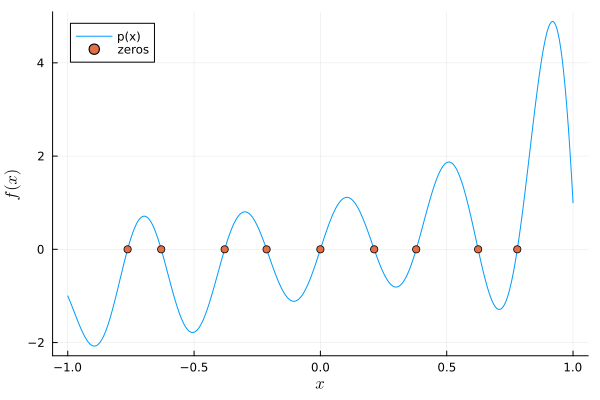

In [17]:
plot_cheb(a,label="p(x)")
scatter!(mid.(ilam),zeros(length(lam)),label="zeros")

補間関数の零点が計算できていることが目視できる。これらは精度保証付きで得られている。

上記の工程をまとめて、Chebyshev係数が区間で与えられた場合には、`chebroots`関数をJuliaの多重ディスパッチ機能で以下のようにする。

In [26]:
function chebroots(ia::Vector{Interval{T}}, I=[-1,1]) where T
    I_lo = I[1]; I_up = I[2]
    a = mid.(ia)

    n = length(ia)
    du = [ones(n-3)*0.5; 1] # no error because there elements are power of 2
    dl = ones(n-2)*0.5 # no error because there elements are power of 2
    d  = zeros(n-1)

    C_1  = Tridiagonal(dl, d, du)
    iC_1 = interval(C_1)
    iC_2 = interval(zeros(n-1,n-1))
    iC_2[:,1] = reverse(ia[1:end-1]/ia[n])
    iC_2 = interval(0.5)*iC_2
    iC = iC_1-iC_2
    C = mid.(iC)

    lam, x = eigen(C)
    ε = 100*eps()*(I_up-I_lo)*0.5
    ind = findall((-1-ε .≤ real(lam) .≤ 1+ε) .& (imag(lam) .≈ 0))
    lam = real(lam[ind]) # Approximate zeros
    x = real(x[:,ind]) # Approximate eigenvector
    ilam = interval(zeros(length(lam)))

    for i = 1:length(lam)
        ilam[i] = verifyeig(iC,lam[i],x[:,i])
    end

    if I_lo==-1.0 && I_up==1.0
        return ilam
    else
        return (interval(1.0) .- ilam).*interval(I_lo)/interval(2) + (interval(1.0) .+ ilam).*interval(I_up)/interval(2)
    end
end

chebroots (generic function with 4 methods)

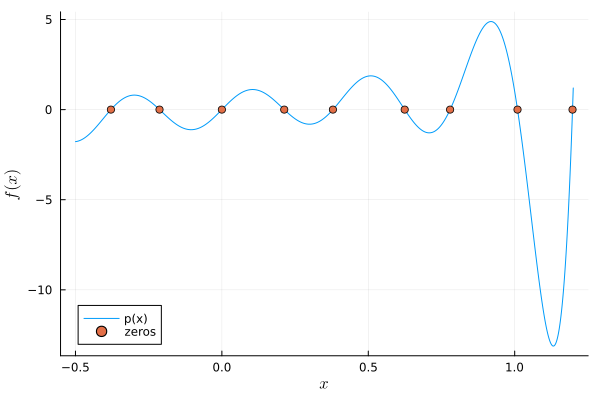

In [29]:
f(x) = exp(erf(x^2) + x.^5) .* sinpi(5x) + x
dom = [-0.5,1.2]
# f(x) = exp(erf(x^2) + x.^5) .* sinpi(5x) + x
# dom = [-1,1]
a = cheb(f,dom)
ia = interval(a)
ilam = chebroots(ia,dom)
plot_cheb(a,I=dom,label="p(x)")
scatter!(mid.(ilam),zeros(length(ilam)),label="zeros")

**注**　毎回、成功すると誤解を招きかねないので、この方法で全部の零点が必ず求められるわけではないことを注意する。例えば、上の例で領域を $[-0.8,1.22]$ とするといくつかの零点（$x\approx -0.763075, -0.212977, 0.624378, 1.19751$）を逃す。これは固有値の精度保証が失敗することが原因である。


┌ Warning: invalid interval, NaI is returned
└ @ IntervalArithmetic /Users/takitoshi/.julia/packages/IntervalArithmetic/rX8mD/src/intervals/construction.jl:417
┌ Warning: interval part of NaI
└ @ IntervalArithmetic /Users/takitoshi/.julia/packages/IntervalArithmetic/rX8mD/src/intervals/construction.jl:299


┌ Warning: invalid interval, NaI is returned
└ @ IntervalArithmetic /Users/takitoshi/.julia/packages/IntervalArithmetic/rX8mD/src/intervals/construction.jl:417
┌ Warning: interval part of NaI
└ @ IntervalArithmetic /Users/takitoshi/.julia/packages/IntervalArithmetic/rX8mD/src/intervals/construction.jl:299


┌ Warning: invalid interval, NaI is returned
└ @ IntervalArithmetic /Users/takitoshi/.julia/packages/IntervalArithmetic/rX8mD/src/intervals/construction.jl:417
┌ Warning: interval part of NaI
└ @ IntervalArithmetic /Users/takitoshi/.julia/packages/IntervalArithmetic/rX8mD/src/intervals/construction.jl:299


┌ Warning: invalid interval, NaI is returned
└ @ IntervalArithmetic /Users/takitoshi/.julia/packages/IntervalArithmetic/rX8mD/src/intervals/construction.jl:417
┌ Warning: interval part of NaI
└ @ IntervalArithmetic /Users/takitoshi/.julia/packages/IntervalArithmetic/rX8mD/src/intervals/construction.jl:299
┌ Warning: interval part of NaI
└ @ IntervalArithmetic /Users/takitoshi/.julia/packages/IntervalArithmetic/rX8mD/src/intervals/construction.jl:299
┌ Warning: interval part of NaI
└ @ IntervalArithmetic /Users/takitoshi/.julia/packages/IntervalArithmetic/rX8mD/src/intervals/construction.jl:299
┌ Warning: interval part of NaI
└ @ IntervalArithmetic /Users/takitoshi/.julia/packages/IntervalArithmetic/rX8mD/src/intervals/construction.jl:299
┌ Warning: interval part of NaI
└ @ IntervalArithmetic /Users/takitoshi/.julia/packages/IntervalArithmetic/rX8mD/src/intervals/construction.jl:299
┌ Warning: interval part of NaI
└ @ IntervalArithmetic /Users/takitoshi/.julia/packages/IntervalArithmeti

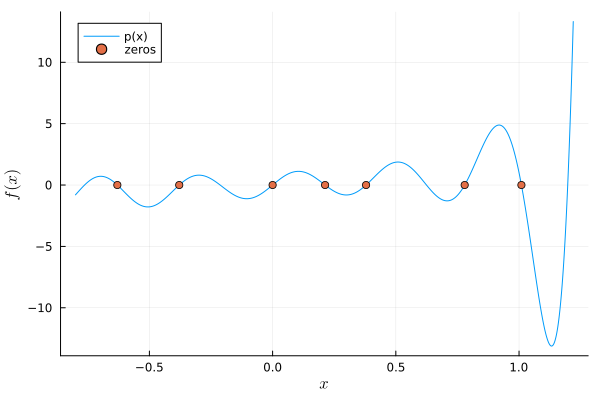

In [30]:
dom = [-.8,1.22]
a = cheb(f,dom)
ia = interval(a)
ilam = chebroots(ia,dom)
plot_cheb(a,I=dom,label="p(x)")
scatter!(mid.(ilam),zeros(length(ilam)),label="zeros")

In [21]:
ilam

11-element Vector{Interval{Float64}}:
 ∅_ill_NG
 [-0.63005, -0.630049]_com
 [-0.378919, -0.378918]_com
 ∅_ill_NG
 [-2.22045e-16, 4.4409e-16]_com
 [0.212965, 0.212966]_com
 [0.379245, 0.379246]_com
 ∅_ill_NG
 [0.779416, 0.779417]_com
 [1.00965, 1.00966]_com
 ∅_ill_NG

## まとめ

Chebyshev補間で与えられた関数の零点をChebyshev係数から計算する方法を紹介した。さらにChebyshev係数を区間で入力することで、零点が精度保証付き数値計算できることも示した。しかしながら、与えた関数 $f(x)$ をChebyshev補間した部分が精度保証されていないため、**関数 $f(x)$ の零点の精度保証ではない**ことに注意したい。

本資料は以下のような文献・Web ページ等を参考に書いています。

### 参考文献

1. I. J. Good, The Colleague Matrix, a Chebyshev analogue of the companion matrix, The Quarterly Journal of Mathematics, 12:1 (1961), pp. 61–68.<br>
(Colleague Matrixの名付け論文（？）だと思います)

1. Lloyd N. Trefethen, Approximation Theory and Approximation Practice, Extended Edition, SIAM, 2019.<br>
(補間理論のマニアックな教科書、18章にChebyshev級数の零点をColleague Matrixを利用して計算する方法が紹介されている。Chebfunを使って実例を見せながら理解させる書き方はとても面白く分かりやすい。本文章のお手本である)

<div align="right">近藤慎佑, <a href="http://www.risk.tsukuba.ac.jp/~takitoshi/">高安亮紀</a>, 2023年4月13日（最終更新：2024年2月5日）</div>